<a href="https://colab.research.google.com/github/Marquezdan/Trabalho_3_ML/blob/main/Learning_Rate_Scheduler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

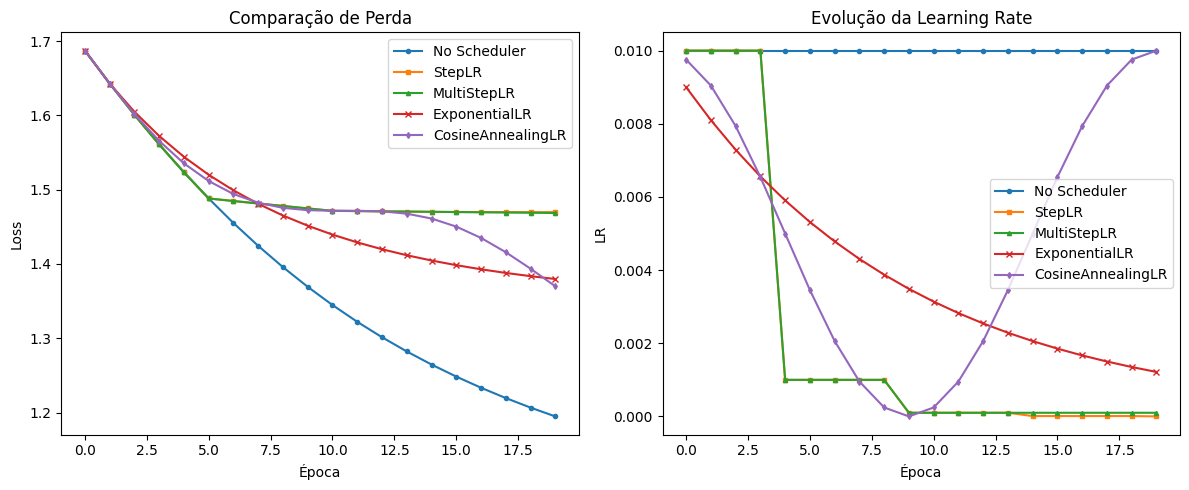

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ==========================================================
# 1. Dados Sintéticos
# ==========================================================
# 100 amostras, 10 features, 1 saída (regressão simples)
X = torch.randn(100, 10)
y = torch.randn(100, 1)

# ==========================================================
# 2. Definição de 5 modelos (iguais) para comparar
# ==========================================================
def create_model():
    return nn.Linear(10, 1)

model_no      = create_model()
model_step    = create_model()
model_multi   = create_model()
model_exp     = create_model()
model_cosine  = create_model()

# Copiando o estado inicial para todos partirem igual
initial_state = model_no.state_dict()
model_step.load_state_dict(initial_state)
model_multi.load_state_dict(initial_state)
model_exp.load_state_dict(initial_state)
model_cosine.load_state_dict(initial_state)

# ==========================================================
# 3. Otimizadores (todos com Adam, LR=0.01)
# ==========================================================
optimizer_no     = optim.Adam(model_no.parameters(),     lr=0.01)
optimizer_step   = optim.Adam(model_step.parameters(),   lr=0.01)
optimizer_multi  = optim.Adam(model_multi.parameters(),  lr=0.01)
optimizer_exp    = optim.Adam(model_exp.parameters(),    lr=0.01)
optimizer_cosine = optim.Adam(model_cosine.parameters(), lr=0.01)

# ==========================================================
# 4. Definindo Schedulers
# ==========================================================
# StepLR: a cada 5 épocas, LR é multiplicada por 0.1
scheduler_step = optim.lr_scheduler.StepLR(optimizer_step, step_size=5, gamma=0.1)

# MultiStepLR: reduz em épocas específicas (ex.: 5 e 10)
scheduler_multi = optim.lr_scheduler.MultiStepLR(optimizer_multi, milestones=[5,10], gamma=0.1)

# ExponentialLR: decai LR a cada época multiplicando por 0.9
scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer_exp, gamma=0.9)

# CosineAnnealingLR: período máximo (T_max=10), depois reinicia
scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer_cosine, T_max=10)

# ==========================================================
# 5. Função de treino (com ou sem scheduler)
# ==========================================================
criterion = nn.MSELoss()

def train_model(model, optimizer, scheduler, use_scheduler, X, y, epochs=20):
    loss_history = []
    lr_history = []
    for epoch in range(epochs):
        # Forward & Loss
        preds = model(X)
        loss = criterion(preds, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Se for usar scheduler, damos o passo aqui
        if use_scheduler:
            scheduler.step()

        # Registrando valores para análise
        loss_history.append(loss.item())
        # get_last_lr() retorna lista (uma por param group), pegamos a primeira
        current_lr = scheduler.get_last_lr()[0] if use_scheduler else optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

    return loss_history, lr_history

# ==========================================================
# 6. Treinando cada modelo (20 épocas)
# ==========================================================
epochs = 20

loss_no,      lr_no      = train_model(model_no,      optimizer_no,     None,              False, X, y, epochs)
loss_step,    lr_step    = train_model(model_step,    optimizer_step,   scheduler_step,    True,  X, y, epochs)
loss_multi,   lr_multi   = train_model(model_multi,   optimizer_multi,  scheduler_multi,   True,  X, y, epochs)
loss_exp,     lr_exp     = train_model(model_exp,     optimizer_exp,    scheduler_exp,     True,  X, y, epochs)
loss_cosine,  lr_cosine  = train_model(model_cosine,  optimizer_cosine, scheduler_cosine,  True,  X, y, epochs)

# ==========================================================
# 7. Plotando as curvas de Loss
# ==========================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(loss_no,     label="No Scheduler", marker='o', ms=3)
plt.plot(loss_step,   label="StepLR",       marker='s', ms=3)
plt.plot(loss_multi,  label="MultiStepLR",  marker='^', ms=3)
plt.plot(loss_exp,    label="ExponentialLR",marker='x', ms=4)
plt.plot(loss_cosine, label="CosineAnnealingLR", marker='d', ms=3)
plt.title("Comparação de Perda")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()

# ==========================================================
# 8. Plotando a evolução da Learning Rate
# ==========================================================
plt.subplot(1,2,2)
plt.plot(lr_no,     label="No Scheduler", marker='o', ms=3)
plt.plot(lr_step,   label="StepLR",       marker='s', ms=3)
plt.plot(lr_multi,  label="MultiStepLR",  marker='^', ms=3)
plt.plot(lr_exp,    label="ExponentialLR",marker='x', ms=4)
plt.plot(lr_cosine, label="CosineAnnealingLR", marker='d', ms=3)
plt.title("Evolução da Learning Rate")
plt.xlabel("Época")
plt.ylabel("LR")
plt.legend()

plt.tight_layout()
plt.show()
